<a href="https://colab.research.google.com/github/jgromero/rl_seminar_2023/blob/main/code/cliffwalking-qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-Learning for _cliff walking_

[**Juan Gómez Romero**](https://ccia.ugr.es/~jgomez)  
Departamento de Ciencias de la Computación e Inteligencia Artificial  
Universidad de Granada  
This work is licensed under the [GNU General Public License v3.0](https://choosealicense.com/licenses/gpl-3.0/).

---

Example based on:
> R.S. Sutton, A.G. Barto (2018) Reinforcement Learning. Chapters 6.5: Q-learning: Off-policy TD Control, 6.6: Expected Sarsa.

_Consider the gridworld shown to the right. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked "The Cliff" Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start._

<img src="https://github.com/jgromero/rl_seminar_2023/blob/main/code/cliffwalking.png?raw=true" width=500/>

> Udacity (2019) Deep Reinforcement Learning Course. Available on [GitHub](https://github.com/udacity/deep-reinforcement-learning/blob/master/temporal-difference/Temporal_Difference_Solution.ipynb).

# Environment

[Gymnasium](https://gymnasium.farama.org/), formerly known as Open AI Gym, is an API standard for reinforcement learning with a diverse collection of reference environments.


In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.4 MB/s eta 0:00:00



[Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) is included as a sample (and simple) environment.



We can instantiate and interact with the environment object [`env`](https://gymnasium.farama.org/api/env/#gymnasium-env) by using a common interface that implements the basic operations if the agent-environment loop.

<img src="https://github.com/jgromero/rl_seminar_2023/blob/main/code/rl-loop.png?raw=true" width=300/>

The main functions are the following (from Gymnasium API [documentation](https://gymnasium.farama.org/api/env/#)):

*   [`reset`](https://gymnasium.farama.org/api/env/#gymnasium.Env.reset): Resets the environment to an initial state, required before calling step. Returns the first agent observation for an episode and information, i.e. metrics, debug info..
*   [`step`](https://gymnasium.farama.org/api/env/#gymnasium.Env.step): Updates an environment with actions returning the next agent observation, the reward for taking that actions, if the environment has terminated or truncated due to the latest action and information from the environment about the step, i.e. metrics, debug info.
*   [`render`](https://gymnasium.farama.org/api/env/#gymnasium.Env.render): Renders the environments to help visualise what the agent see, examples modes are “human”, “rgb_array”, “ansi” for text.
*   [`close`](https://gymnasium.farama.org/api/env/#gymnasium.Env.close): Closes the environment, important when external software is used, i.e. pygame for rendering, databases

Next we can see a simple example of a random agent interacting with the environment 100 times. Each action is a random sample taken from the [`action_space`](https://gymnasium.farama.org/api/vector/#action_space) vector.

In [21]:
import gymnasium as gym

# Create the environment
env = gym.make("CliffWalking-v0", render_mode="ansi")   # change to "human" in local mode

# Start the environment
observation, info = env.reset(seed=42)

# Interact 100 times with the environment.
# The action applied at each step is a random action sampled from the
for i in range(100):
   action = env.action_space.sample()  # this is where you would insert your policy

   #print(f"Selected action {action} at step {i}")

   observation, reward, terminated, truncated, info = env.step(action)

   #print(f"Reward obtained {reward}\n")
   #print(f"Next state {observation}")

   if terminated or truncated:   # restart the environment if terminated
      observation, info = env.reset()

env.close()

The details of the environment definition can be found at the [Gymnasium documentation for Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/).

## Q-Learning algorithm
Next we have a basic implementation of the Q-Learning algorithm. Remember the update rule of the $Q$ table:

$Q(S_t, A_t) ← Q(S_t, A_t) + α·[R_t+γmax_{A_{t+1}}Q(S_{t+1}, A_{t+1})-Q(S_t,A_t)]$

In [52]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict, deque

def generate_action_from_Q_epsilon(discrete_env, Q, epsilon, state):
    """Action generator: Gets action for Q implicit policy
    Params
    ======
    env: environment, must have a discrete action space
    Q: Q table, defined as a dict Q[state][action] = reward
    state: current state
    bins: discretizacion intervals for the state values
    epsilon: value for epsilon-greedy"""

    r = np.random.uniform(size=1)[0]
    if r <= epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state])

    return action

def qlearning(env, num_episodes, generate_action, step_limit=1000, gamma=1.0, alpha=0.01, epsilon=0.2, plot_every=100):
    """Q-Learning algorithm: Approximates an optimal policy by refining Q
    Params
    ======
    env: environment, must have a discrete action space
    num_episodes: number of episodes for training
    generate_accion: function to generate the next action
    gamma: discount rate
    epsilon: value for epsilon-greedy
    alpha: alpha value
    render: how to render environment"""

    # initialize Q table to zeros
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Q

    # initialize auxiliary vectors for temporal scores
    tmp_scores = deque(maxlen=plot_every)               # score of the last 'plot_every' episodes
    avg_scores = deque(maxlen=num_episodes//plot_every) # average score of each 'plot_every'-episode group

    for i_episode in range(1, num_episodes+1):

        # progress monitoring
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # start episode
        state, _   = env.reset()
        done = False
        episode_score = 0
        n_step = 0

        # loop episode
        while True :
            # choose action (off policy)
            action = generate_action(env, Q, epsilon, state)

            # apply action and update episode score
            next_state, reward, terminated, _, _ = env.step(action)
            episode_score += reward

            # update Q
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])

            # check end of episode
            n_step += 1
            if done or n_step > step_limit:
                tmp_scores.append(episode_score)
                break

            # get next state
            state = next_state

        # change epsilon
        epsilon = 1 / i_episode

        # end episode
        if(i_episode % plot_every == 0):
          avg_scores.append(np.mean(tmp_scores))

    # visualize scores
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode number')
    plt.ylabel('Average score of the last %d episodios' % plot_every)
    plt.show()
    print(('Best average score: '), np.max(avg_scores))

    # build policy from Q table
    policy = dict((k,np.argmax(v)) for k, v in Q.items())

    return Q, policy

We can now run our `qlearning` function on the environment.

In [ ]:
env = gym.make("CliffWalking-v0", render_mode="ansi")   # change to "human" in local mode

Q, policy = qlearning(env, 25000, generate_action_from_Q_epsilon)

Episode 4500/25000.

The resulting policy is the following.

In [42]:
policy_plot = np.array([policy[key] if key in policy else -1 for key in np.arange(48)]).reshape(4, 12)
print("\nEstimated optimal policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_plot)


Estimated optimal policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  3  2  2  0  3  1  0  0  3  2  1]
 [ 3  3  3  1  1  2  0  1  0  0  0  0]
 [ 0  3  3  3  0  3  0  0  0  0  1  0]
 [ 2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2]]


We can visualize the values of the state-value function $v_\pi$ for the estimated policy $\pi$ and compare them with the optimal policy values $v_{\pi_*}$.

(The `plot_values()` function is required for the visualization.)

In [46]:
def plot_values(V):
	# reshape the state-value function
	V = np.reshape(V, (4,12))
	# plot the state-value function
	fig = plt.figure(figsize=(15,5))
	ax = fig.add_subplot(111)
	im = ax.imshow(V, cmap='cool')
	for (j,i),label in np.ndenumerate(V):
	    ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
	plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
	plt.title('State-Value Function')
	plt.show()

__State-value function for the agent's learnt policy $v_\pi$__

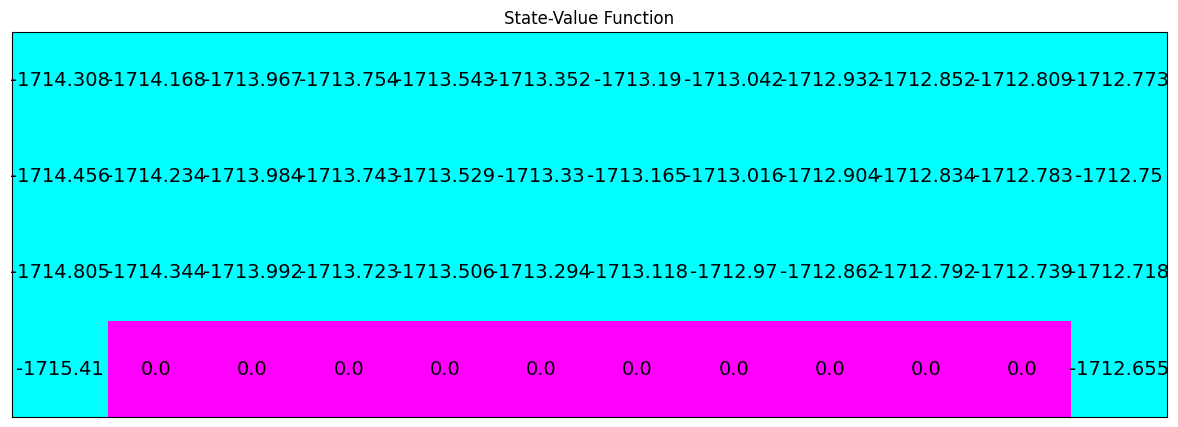

In [47]:
V = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])
plot_values(V)

__State-value function for the optimal policy  $v_{\pi_*}$__

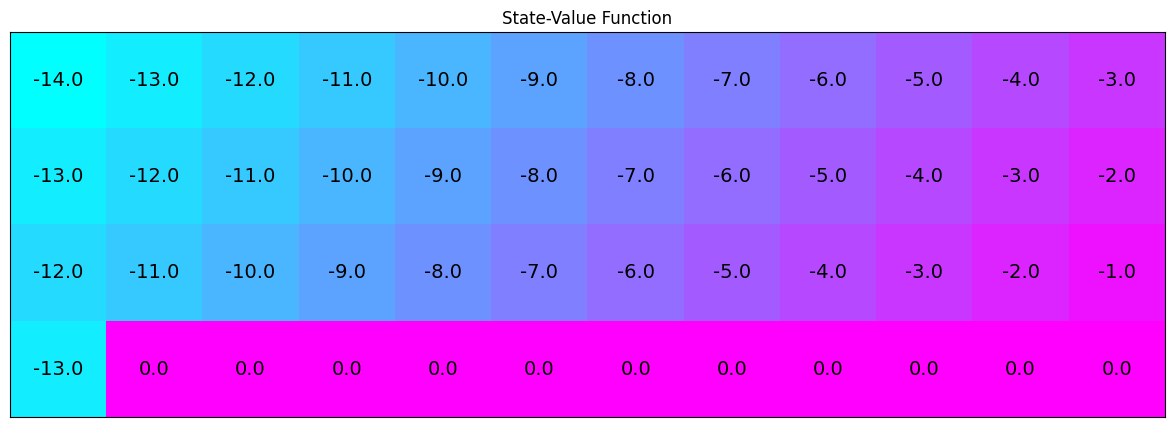

In [45]:
# The state-values for the optimal policy can be manually calculated
V_opt = np.zeros((4,12))
V_opt[0][0:13] = -np.arange(3, 15)[::-1]
V_opt[1][0:13] = -np.arange(3, 15)[::-1] + 1
V_opt[2][0:13] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13
plot_values(V_opt)

# EXERCISE

Modify $\epsilon$ in `qlearning` to make it change during the training process. For instance: $\epsilon = 1 / i\_episode$.